In [2]:
import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


Implementing Green's function method use to evaluate Equilibrium Josephson current distributions outlined in: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.94.094514.
The salient expression for the equilibrium current density is given by:
$$ \mathbf{j}(\mathbf{r}) = 2e k_{B}T  \ \textrm{Re}\sum_{p = 0}^{\infty} \langle \mathbf{r} | \hat{G}(i\omega_{p}) | \mathbf{r} \rangle \langle \mathbf{r} | \frac{1}{\hbar} \partial_{\mathbf{k}}\hat{H} | \mathbf{r}\rangle  $$

In [90]:
def make_SNS(a , t , D , e_f , L , W , flux , phase):
    # a = 1
    # t = 1
    # D = 1
    # e_f = 0.5
    # L = 2
    # W = 2
    # flux = 5 # Flux through normal region in units of superconducting fluxon.
    B = flux / (L*W)
    # phase = 0.25 # Superconducting phase difference in units of 2\pi
    syst = kwant.Builder()
    lat = kwant.lattice.square(a = a , norbs= 2)

    for i in range(int(W/a)):
        for j in range(int(L / a)):

            syst[lat(i , j)] = 4*(t/a**2)*sz - e_f*sz

            if i > 0:
                syst[lat(i , j) , lat(i-1 , j)] = -(t/a**2)*sz
            if j > 0:
                phase = np.exp(1j*B*i*a*a/0.5)
                syst[lat(i , j) , lat(i , j-1)] = -(t/a**2)*(sz@np.diag([phase , phase.conj()]))

    sym_2 = kwant.TranslationalSymmetry((0 , a))
    lead_2 = kwant.Builder(sym_2)

    for i in range(int(W/a)):
        lead_2[lat(i , 0)] = 4*(t/a**2)*sz - e_f*sz + D*np.exp(1j*phase*2*np.pi)*(0.5*(sx + 1j*sy)) + D*np.exp(-1j*phase*2*np.pi)*(0.5*(sx - 1j*sy))

        if i > 0:
            lead_2[lat(i , 0) , lat(i-1 , 0)] = -(t/a**2)*sz
        lead_2[lat(i , 1) , lat(i , 0)] = -(t/a**2)*sz

    sym_1 = kwant.TranslationalSymmetry((0 , -a))
    lead_1 = kwant.Builder(sym_1)

    for i in range(int(W/a)):
        lead_1[lat(i , 0)] = 4*(t/a**2)*sz - e_f*sz + D*sx

        if i > 0:
            lead_1[lat(i , 0) , lat(i-1 , 0)] = -(t/a**2)*sz
        lead_1[lat(i , 1) , lat(i , 0)] = -(t/a**2)*sz

    syst.attach_lead(lead_1)
    syst.attach_lead(lead_2)

    syst = syst.finalized()
    return syst

In [91]:
syst = make_SNS(a =1 , t = 1 , D = 1, e_f = 0.5 , L = 2 , W = 2 , flux = 5 , phase = 0.25)
greensfunction = kwant.greens_function(syst , energy = 1j*np.pi*0.01 , check_hermiticity=False)

Text(0.5, 1.0, '$\\textrm{Re}\\hat{G}^{R}(\\varepsilon|\\mathbf{p} , \\mathbf{q})$')

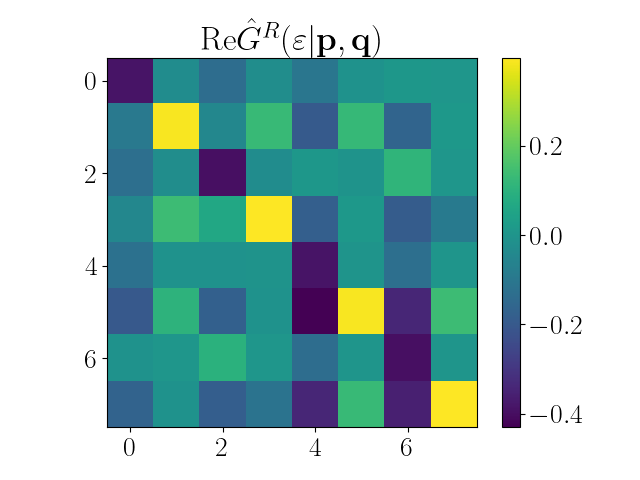

In [92]:
plt.figure()
plt.imshow(np.real(greensfunction.data))
plt.colorbar()
plt.title(r'$\textrm{Re}\hat{G}^{R}(\varepsilon|\mathbf{p} , \mathbf{q})$')

(4, 4)


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

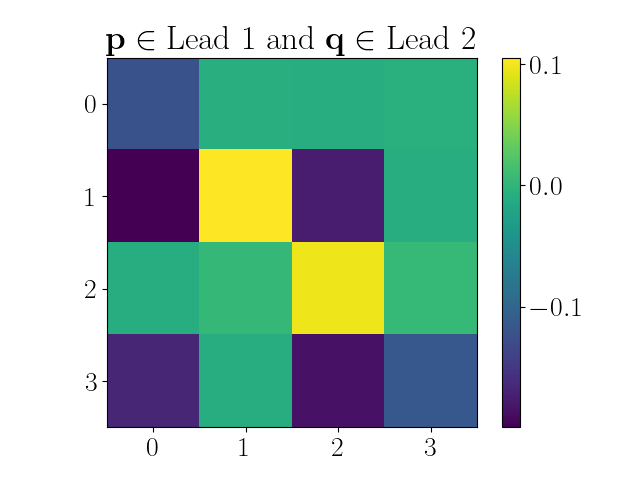

In [93]:
g_10 = greensfunction.submatrix(1 , 0)
plt.figure()
plt.imshow(np.real(g_10))
plt.colorbar()
plt.title(r'$\mathbf{p} \in \textrm{Lead 1} \ \textrm{and} \ \mathbf{q} \in \textrm{Lead 2}$')
print(g_10.shape)
plt.tight_layout


Let's just try inverting the matrix lol:

In [100]:
H_quart = make_SNS(a =1 , t = 1 , D = 1, e_f = 0.5 , L = 2 , W = 2 , flux = 5 , phase = 0.25).hamiltonian_submatrix()
H_0= make_SNS(a =1 , t = 1 , D = 1, e_f = 0.5 , L = 2 , W = 2 , flux = 5 , phase = 0.0).hamiltonian_submatrix()
def GrünFunktion(e , T, ham , matsubara = False):
    energy = e
    if matsubara == True:
        energy *= 1j*T*e*np.pi      
    ham_dim = ham.shape[0]
    return np.linalg.inv(energy*np.identity(ham_dim) - ham)

green_0 = GrünFunktion( 1 , 0.1 ,  H_0 , matsubara=True)
green_quart = GrünFunktion( 1 , 0.1 ,  H_quart , matsubara=True)

In [101]:
green_quart == green_0

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])